In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [4]:
comp=pd.read_csv("Company.csv")
comp_tw=pd.read_csv("Company_Tweet.csv")
tw=pd.read_csv("Tweet.csv")

In [5]:
comp.head()

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc
2,GOOGL,Google Inc
3,AMZN,Amazon.com
4,TSLA,Tesla Inc


In [6]:
comp.shape

(6, 2)

In [7]:
comp_tw.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [8]:
comp_tw.shape

(4336445, 2)

In [9]:
tw.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [10]:
tw.shape

(3717964, 7)

In [11]:
dic=pd.Series(comp.company_name.values,index=comp.ticker_symbol).to_dict()
comp_tw.ticker_symbol=comp_tw.ticker_symbol.map(dic)
dic2=pd.Series(comp_tw.ticker_symbol.values,index=comp_tw.tweet_id).to_dict()
tw.tweet_id=tw.tweet_id.map(dic2)
tw.rename(columns={"tweet_id":"company_name"},inplace=True)

In [12]:
stop_words=stopwords.words('english')
def remove_stopwords(txt):
    words=word_tokenize(txt)
    words=[w for w in words if w.isalpha()]
    words=[w for w in words if not w in stop_words]
    return ' '.join(words)

tw.body = tw["body"].apply(remove_stopwords)


In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bhatt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
sia=SentimentIntensityAnalyzer()

dict_sent=tw["body"].apply(lambda z:sia.polarity_scores((z)))
print(dict_sent)
positive=[]
negative=[]
neutral=[]
sentiment=[]
compound=[]
for w in dict_sent:
    positive.append(w['pos'])
    negative.append(w['neg'])
    neutral.append(w['neu'])
    compound.append(w["compound"])
    if (w['compound']>0.05):
        sentiment.append("positive")
    elif (w['compound']<-0.05):
        sentiment.append("negative")
    else:
        sentiment.append("neutral")


0          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1          {'neg': 0.442, 'neu': 0.558, 'pos': 0.0, 'comp...
2          {'neg': 0.143, 'neu': 0.857, 'pos': 0.0, 'comp...
3          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                                 ...                        
3717959    {'neg': 0.114, 'neu': 0.775, 'pos': 0.111, 'co...
3717960    {'neg': 0.211, 'neu': 0.682, 'pos': 0.107, 'co...
3717961    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3717962    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3717963    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: body, Length: 3717964, dtype: object


In [15]:
dic3={"positive":positive,"negative":negative,"neutral":neutral,"compound":compound,"sentiment":sentiment}
data2=pd.DataFrame(dic3)
data3=[tw,data2]
data=pd.concat(data3,axis=1)
data.isnull().sum()

company_name        0
writer          47273
post_date           0
body                0
comment_num         0
retweet_num         0
like_num            0
positive            0
negative            0
neutral             0
compound            0
sentiment           0
dtype: int64

In [16]:
data.post_date=data.post_date.apply(lambda z:datetime.fromtimestamp(z))
print(data["post_date"])
data.post_date=pd.to_datetime(data.post_date)
data=data.assign(day=data.post_date.dt.day,month=data.post_date.dt.month,year=data.post_date.dt.year)
data.drop("post_date",axis=1,inplace=True)
data.year.value_counts()

0         2015-01-01 05:30:57
1         2015-01-01 05:31:36
2         2015-01-01 05:31:50
3         2015-01-01 05:36:47
4         2015-01-01 05:40:05
                  ...        
3717959   2020-01-01 05:23:03
3717960   2020-01-01 05:23:21
3717961   2020-01-01 05:24:03
3717962   2020-01-01 05:25:37
3717963   2020-01-01 05:25:53
Name: post_date, Length: 3717964, dtype: datetime64[ns]


2016    842679
2018    766757
2019    759484
2015    727383
2017    621071
2020       590
Name: year, dtype: int64

# % of tweets received by each company

<AxesSubplot:ylabel='company_name'>

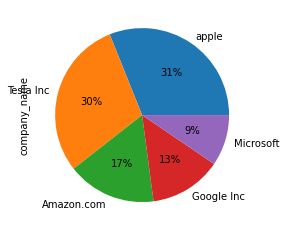

In [17]:
data.company_name.value_counts().plot(kind="pie",autopct="%1.0f%%")

# tweets in different years

<AxesSubplot:ylabel='year'>

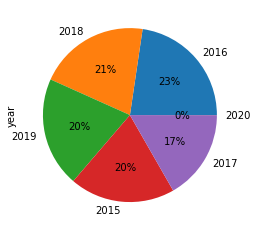

In [18]:
data.year.value_counts().plot(kind="pie",autopct="%1.0f%%")

# Tweets with positive, negative and neutral sentiment received by each company

(0.0, 100.0)

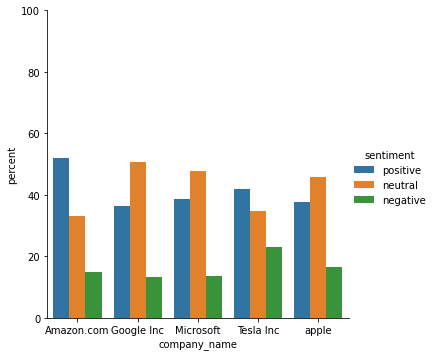

In [19]:
x,y="company_name","sentiment"
df1 = data.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

# Ratings based on the sentiment score.

In [20]:
data["rating"]=round(data["compound"]*2+3)

data.rating.value_counts()
data.dtypes
print(round(data.groupby("company_name",as_index=False)["rating"].mean(),1))

  company_name  rating
0   Amazon.com     3.3
1   Google Inc     3.2
2    Microsoft     3.2
3    Tesla Inc     3.2
4        apple     3.3


In [21]:
data["rating"]=data.rating.astype("category")

In [22]:
data.dtypes

company_name      object
writer            object
body              object
comment_num        int64
retweet_num        int64
like_num           int64
positive         float64
negative         float64
neutral          float64
compound         float64
sentiment         object
day                int64
month              int64
year               int64
rating          category
dtype: object

# Top 10 authors whom tweets result in poor rating of the companies. 

In [23]:
author=data.groupby(["writer"]).sum().nsmallest(10,"compound").reset_index().writer
print(author)

0     MelaynaLokosky
1        TradingGuru
2    GlobalInvestor5
3    Maximum_Pain_cm
4      BertelSchmitt
5            bgamall
6    Wise_Owl_Trader
7            Dope007
8           SamAntar
9         PollsTesla
Name: writer, dtype: object


# Companies trolled

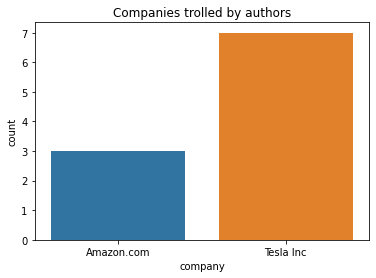

In [24]:
company=[]
for w in author:
    company.append(data.loc[data['writer'] == w, 'company_name'].iloc[0])
troll=pd.DataFrame(list(zip(author,company)),columns=['author','company'])
sns.countplot(x="company",data=troll).set_title("Companies trolled by authors")
plt.show()

In [25]:
data.drop(["writer","body","day","month","year"],axis=1,inplace=True)

In [26]:
le_comp=LabelEncoder()
le_sent=LabelEncoder()

data["company_name"]=le_comp.fit_transform(data["company_name"])
data["sentiment"]=le_sent.fit_transform(data["sentiment"])



In [27]:
y=data["rating"]
x=data.drop("rating",axis=1)
x=x.values
#x=PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)


In [28]:
data["rating"].value_counts()

3.0    1957269
4.0    1036135
2.0     456627
5.0     224211
1.0      43722
Name: rating, dtype: int64

# Let us look at the performance of different classifiers

# 1. Decision Tree Classifier

In [29]:
model = DecisionTreeClassifier(random_state=0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      8728
         2.0       1.00      1.00      1.00     91061
         3.0       1.00      1.00      1.00    391717
         4.0       1.00      1.00      1.00    207201
         5.0       1.00      1.00      1.00     44886

    accuracy                           1.00    743593
   macro avg       1.00      1.00      1.00    743593
weighted avg       1.00      1.00      1.00    743593

[[  8728      0      0      0      0]
 [     0  91061      0      0      0]
 [     0      0 391717      0      0]
 [     0      0      0 207201      0]
 [     0      0      0      0  44886]]


In [30]:
model=RandomForestClassifier(n_estimators=5)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      8728
         2.0       1.00      1.00      1.00     91061
         3.0       1.00      1.00      1.00    391717
         4.0       1.00      1.00      1.00    207201
         5.0       1.00      1.00      1.00     44886

    accuracy                           1.00    743593
   macro avg       1.00      1.00      1.00    743593
weighted avg       1.00      1.00      1.00    743593

[[  8726      2      0      0      0]
 [     1  91060      0      0      0]
 [     0      0 391717      0      0]
 [     0      0      0 207201      0]
 [     0      0      0      0  44886]]


# Gradient Boosting Classifier

In [31]:
model=GradientBoostingClassifier(n_estimators=5)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      8728
         2.0       1.00      1.00      1.00     91061
         3.0       1.00      1.00      1.00    391717
         4.0       1.00      1.00      1.00    207201
         5.0       1.00      1.00      1.00     44886

    accuracy                           1.00    743593
   macro avg       1.00      1.00      1.00    743593
weighted avg       1.00      1.00      1.00    743593

[[  8728      0      0      0      0]
 [     0  91061      0      0      0]
 [     0      0 391717      0      0]
 [     0      0      0 207201      0]
 [     0      0      0      0  44886]]
